# Predicting Salaries & Web Scraping
## Scraping Indeed.com

In [2]:
import numpy as np
import pandas as pd
import requests
import time
from bs4 import BeautifulSoup

In [3]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt
import numpy as np
import pickle as pk
import re




Simple Class to output a nice graphic with words, where size of words = occurances

In [4]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)

In [5]:
def pltbarangcantik(df):
    text = ''
    for kerja in df['jobs'].unique():
        text += (str(kerja) + ' ') * int(df.importance[kerja] * 10000)

    positives = [str(index) for index in df.head(20).index if df.impact_coef[index]>0]
    negatives = [str(index) for index in df.head(20).index if df.impact_coef[index]<0]

    # Since the text is small collocations are turned off and text is lower-cased
    wc = WordCloud(background_color="white", collocations=False).generate(text.lower())

    color_to_words = {'blue': positives, 'brown': negatives}

    default_color = 'black'

    # Create a color function with single tone
    grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

    # Apply our color function
    wc.recolor(color_func=grouped_color_func)

    # Plot
    plt.figure(figsize=(12,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


Perhaps a better scraper than Irvin's

In [6]:
Countries = {"SG":"Singapore","US":"United States","MY":"Malaysia","HK":"Hong Kong","ID":'Indonesia'}

Target_cities= {'US':
                      ['New York', 'Chicago', 'San Francisco', 'Austin', 'Seattle',
                  'Los Angeles', 'Philadelphia', 'Atlanta', 'Dallas',
                  'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston','Miami'],
                'SG':["Singapore"],
                'MY':['Kuala Lumpur','Johor Bahru','Shah Alam'],
                'HK':['Hong Kong'],
                'ID':['Jakarta','Batam','Surabaya']
                }

In [7]:
URL = {"SG":"https://www.indeed.com.sg/jobs",
       "US":"https://www.indeed.com/jobs",
       "MY":"https://www.indeed.com.my/jobs",
       "HK":"https://www.indeed.hk/jobs",
       "ID":"https://id.indeed.com/lowongan-kerja"
       
       }

In [8]:
max_results_per_city = 1000
#put data scientist as a placeholder, will be filled with the list of jobs later
parameters = {'q': 'data scientist', 'radius': '100', 'start':1}
#list of jobs
jobs = ['data scientist','data analyst']

In [9]:
def scrape_page_to_df(url, url_params,country):
    """
    extract information from a results page and save to an existing csv
    :param url: url template
    :param url_params: a dictionary to feed to params argument in requests.get (based on the parameters I defined above, and I'll make a wrapper to do this below)
    :return: a pandas dataframe containing the extracted information
    """
    # create a empty dictionary to store extracted information
    scraped_data = {'location': [],
                  'company': [],
                  'title': [],
                  'salary': [],
                  'description': [],
                  'review': [],
                  'star': [],
                  'country':[]
                  }

    html = requests.get(url, params=url_params)

    # make sure the response status is ok
    assert html.status_code == requests.codes.ok

    soup = BeautifulSoup(html.text, 'lxml')

  #helper function to extract results

    def extract_results(soup):
        return soup.find_all('div', class_='result')

    results = extract_results(soup)

  #helper functions to extract information
    def extract_location(result):
        """extract job location"""
        try:
            location = result.find('span', class_='location').get_text().strip()
            return location
        except:
            return None


    def extract_company(result):
        """extract the name of the company"""
        try:
            company = result.find('span', class_='company').get_text().strip()
            return company
        except:
            return None

    def extract_title(result):
        """extract the job title"""
        try:
            title = result.find('a', attrs={'data-tn-element': "jobTitle"}).get('title')
            return title
        except:
            return None


    def extract_salary(result):
        """extract the salary"""
        try:
            salary = result.find('td', class_='snip').\
            find('span', class_='no-wrap').\
            get_text().strip()
            return salary
        except:
            return None


    def extract_description(result):
        """extract job description snippet"""
        try:
            description = result.find('span', class_='summary').get_text().strip()
            return description
        except:
            return None


    def extract_review(result):
        """extract the number of reviews for the company"""
        try:
            review = result.find('a', attrs={'data-tn-element': "reviewStars"})
            review = review.find('span', class_="slNoUnderline")
            review = review.get_text().strip()
            # extract only the number
            review = review.replace(',', '').replace(' reviews', '')
            return review
        except:
            return None            

    
    def extract_star(result):
        """extract a number (width) that is proportional to the number of stars
        shown for the company"""
        try:
            # the 'style' attribute dictates how many stars are filled with color
            star = result.find('span', class_='rating').get('style')
            # extract only the number
            star = star.replace('width:', '').replace('px', '')
            return star
        except:
            return None


    # append extracted info to the correspond list
    for result in results:
        scraped_data['location'].append(extract_location(result))
        scraped_data['company'].append(extract_company(result))
        scraped_data['title'].append(extract_title(result))
        scraped_data['salary'].append(extract_salary(result))
        scraped_data['description'].append(extract_description(result))
        scraped_data['review'].append(extract_review(result))
        scraped_data['star'].append(extract_star(result))
        scraped_data['country'].append(country)

      # convert the dictionary to a pandas dataframe and returns it
    return pd.DataFrame(scraped_data)


helper function to remove duplicates

In [10]:
def remove_duplicates(df):
    """remove duplicates and returns a new df"""
    
    nrows_before = df.shape[0]
    df.drop_duplicates(subset=['company', 'country','description',
                               'location', 'salary', 'title'],
                       keep='last', inplace=True)
    nrows_after = df.shape[0]
    
    print('{} rows remain after removing duplicates from {} rows.'.format(
        nrows_after, nrows_before))
    print('{} rows have salary info; {} rows have yearly salary info.'.format(
      df.salary.notnull().sum(), df.salary.str.contains('year').sum()))
    return df

In [11]:
def scrapper(CountryCode):
    print('Current system time: {}'.format(time.ctime()))
    
   
  
    # scrape data and save to dataframe
    start_time = time.time()
    
    #Retrieve Parameters to scrape with based on input of Country Code
    url = URL[CountryCode]
    locations = Target_cities[CountryCode]
    country = Countries[CountryCode]
    
    #Create an empty place holder df, search through every location in that country, but only 1 results, just to get the title and columns
    df = scrape_page_to_df(url,parameters,country)
    
    
    for tempat in locations:
        for kerja in jobs:
            for start in range(0, max_results_per_city, 10):
            
              
                url_params = parameters.copy()
                #update the job with the target job that we want, city for target city that we are looking for and start refers to the current page number being scrapped
                url_params.update({'l': tempat,'q': kerja, 'start': start})


                #insert code to put the scrap stuff into a df here, after each round of loop, concat into a df
                df = pd.concat([df,scrape_page_to_df(url, url_params,country)],axis=0)
              
        print('Finished scraping {}'.format(tempat))
    total_time = (time.time() - start_time) / 60
    print('Scraping run time: {:.1f} minutes'.format(total_time))

    
    
    
    # remove duplicates
    df = remove_duplicates(df)
    print('Script finished at {}\n'.format(time.ctime()))
    
    #returns the final df
    return df

In [12]:
SG = scrapper('SG')

Current system time: Fri Oct 27 14:03:50 2017


KeyboardInterrupt: 

In [ ]:
SG.to_pickle('./data/SG.pkl')
SG.to_csv('./data/SG.csv')

In [ ]:
ID = scrapper('ID')

In [ ]:
ID.to_pickle('./data/ID.pkl')
ID.to_csv('./data/ID.csv')

In [ ]:
US = scrapper('US')

In [ ]:
US.to_pickle('./data/US.pkl')
US.to_csv('./data/US.csv')

In [ ]:
HK= scrapper('HK')

In [ ]:
HK.to_pickle('./data/HK.pkl')
HK.to_csv('./data/HK.csv')

In [ ]:
MY=scrapper("MY")


In [ ]:
MY.to_pickle('./data/MY.pkl')
MY.to_csv('./data/MY.csv')

## Load Pickle

In [13]:
import pickle

In [14]:
SG = pickle.load(open('./data/SG.pkl',mode='rb'))
US = pickle.load(open('./data/US.pkl',mode='rb'))
MY = pickle.load(open('./data/MY.pkl',mode='rb'))
HK = pickle.load(open('./data/HK.pkl',mode='rb'))
ID = pickle.load(open('./data/ID.pkl',mode='rb'))

In [15]:
alldf =[SG,MY,ID,US,HK]

In [16]:
SG.head()

,company,country,description,location,review,salary,star,title
3,Singapore Power,Singapore,"Singapore Power is looking for data analysts, ...",Singapore,6,None,51.0,Data Analyst/Data Scientist/Data and Machine L...
4,Skyscanner,Singapore,What you can expect as a data scientist. Previ...,Singapore,3,None,51.0,Data Scientist – Singapore
5,Siemens AG,Singapore,Siemens Healthineers is hiring a Data Scientis...,Singapore,5293,None,51.6,Data Scientist
6,GIC Investment,Singapore,Acquire data from primary or secondary data so...,Tanjong Pagar,None,None,None,"VP, Data Scientist"
7,Procter & Gamble,Singapore,"Scope includes acquiring, cleaning, formatting...",Singapore,3703,None,52.2,Research & Development - Data Transformation S...


In [17]:
SG.dtypes

company        object
country        object
description    object
location       object
review         object
salary         object
star           object
title          object
dtype: object

In [18]:
ID['review'].unique()

array([None, '4 ulasan', '3.881 ulasan', '11.374 ulasan', '2 ulasan',
       '859 ulasan', '5.057 ulasan', '3.076 ulasan', '5.293 ulasan',
       '18.049 ulasan', '5.328 ulasan', '243 ulasan', '12.507 ulasan',
       '2.476 ulasan', '1.434 ulasan', '5 ulasan', '3 ulasan',
       '437 ulasan', '11.048 ulasan', '2.653 ulasan', '7.550 ulasan',
       '199 ulasan', '14 ulasan'], dtype=object)

In [19]:
def getridulasan(x):
    if type(x) == str:
        try:
            x = x.replace('ulasan',"")
        except:
            pass
    return x
for i in alldf:
    i['review'] = i['review'].apply(getridulasan)
    i['review'] = i['review'].astype(float)
    i['star'] = i['star'].astype(float)

## Currency Exchange Rates to SGD

In [20]:
Forex = {
        "SGD":1,
         "USD":1.36,
         "RM":0.32,
         "IDR":0.000100588169,
         "HKD":0.174239098
        }
Currency = {"Singapore":'SGD',"United States":'USD',"Malaysia":'RM',"Indonesia":'IDR',"Hong Kong":"HKD"}

### Get the currency

In [21]:
for country in alldf:
    country['currency'] = Currency[country['country'][1].unique()[0]]

In [22]:
ID.head()

,company,country,description,location,review,salary,star,title,currency
1,"PT United Tractors, Tbk",Indonesia,The person also need to have deep understandin...,Indonesia,NaN,None,NaN,Data Scientist,IDR
5,Nielsen,Indonesia,Leading a team of Data Scientist :. 10 years D...,Indonesia,NaN,None,NaN,Data Science Leader,IDR
6,PT Xtremax Teknologi Indonesia,Indonesia,At least 2 years experiences working with data...,Bandung,NaN,None,NaN,Data Scientist,IDR
0,Atreus Global,Indonesia,Data mining using state-of-the-art methods. Pr...,Jakarta,NaN,None,NaN,Data Scientist,IDR
1,HappyFresh,Indonesia,Understanding of reporting systems and efficie...,Jakarta,NaN,None,NaN,Data Scientist,IDR


### Form a superdf

In [23]:
df = pd.concat([SG,ID,US,HK,MY],copy=True).reset_index(drop=True)

#### Take the ones with salary

In [24]:
train = df.dropna(axis=0,subset=['salary'])

#### Create a test set tthat is the difference between train and the full df

In [121]:
test = df.iloc[df.index.difference(train.index)]

In [122]:
test.head()

,company,country,description,location,review,salary,star,title,currency
0,Singapore Power,Singapore,"Singapore Power is looking for data analysts, ...",Singapore,6.0,None,51.0,Data Analyst/Data Scientist/Data and Machine L...,SGD
1,Skyscanner,Singapore,What you can expect as a data scientist. Previ...,Singapore,3.0,None,51.0,Data Scientist – Singapore,SGD
2,Siemens AG,Singapore,Siemens Healthineers is hiring a Data Scientis...,Singapore,5293.0,None,51.6,Data Scientist,SGD
3,GIC Investment,Singapore,Acquire data from primary or secondary data so...,Tanjong Pagar,NaN,None,NaN,"VP, Data Scientist",SGD
4,Procter & Gamble,Singapore,"Scope includes acquiring, cleaning, formatting...",Singapore,3703.0,None,52.2,Research & Development - Data Transformation S...,SGD


In [27]:
test.shape

(22773, 9)

In [28]:
train.shape

(1591, 9)

In [29]:
train.head()

,company,country,description,location,review,salary,star,title,currency
8,UMeKang,Singapore,"Use all available data, undertaking data disco...",Singapore,NaN,"$9,000 - $11,000 a month",NaN,Data Scientist,SGD
21,Cresco Data Pte Ltd,Singapore,Data Scientist Duties:. We are looking for a D...,Tanjong Pagar,NaN,"$3,500 - $4,500 a month",NaN,Data Scientist,SGD
29,Vault Dragon,Singapore,Assist the Data Scientist in deploying Machine...,Singapore,NaN,"$4,000 - $6,000 a month",NaN,Data Engineer,SGD
34,TSA Solutions,Singapore,Data Scientist - Summary*. Bachelor in degree ...,Pasir Panjang,NaN,"$4,200 a month",NaN,Data Scientist,SGD
39,EkkBaz.com,Singapore,We are looking for a Data Scientist that will ...,Ang Mo Kio,NaN,"$1,000 - $2,000 a month",NaN,Data Scientist Intern,SGD


In [30]:
ID['salary'].unique()

array([None, 'Rp. 1.800.000 per bulan',
       'Rp. 3.500.000 - Rp. 4.500.000 per bulan',
       'Rp. 8.000.000 - Rp. 10.000.000 per bulan',
       'Rp. 4.000.000 - Rp. 5.000.000 per bulan',
       'Rp. 4.500.000 per bulan',
       'Rp. 9.000.000 - Rp. 11.000.000 per bulan',
       'Rp. 5.500.000 - Rp. 8.000.000 per bulan',
       'Rp. 2.500.000 - Rp. 3.000.000 per bulan',
       'Rp. 5.000.000 per bulan',
       'Rp. 2.000.000 - Rp. 2.500.000 per bulan',
       'Rp. 3.300.000 - Rp. 8.000.000 per bulan',
       'Rp. 4.500.000 - Rp. 7.500.000 per bulan',
       'Rp. 4.000.000 - Rp. 6.000.000 per bulan',
       'Rp. 3.000.000 per bulan',
       'Rp. 4.000.000 - Rp. 8.000.000 per bulan',
       'Rp. 3.000.000 - Rp. 3.500.000 per bulan',
       'Rp. 3.000.000 - Rp. 5.000.000 per bulan',
       'Rp. 3.000.000 - Rp. 4.000.000 per bulan',
       'Rp. 2.000.000 - Rp. 10.000.000 per bulan'], dtype=object)

### Indonesian

## Translate

In [31]:
def translate(yalam):
    translate = {"bulan":"month","tahun":"year",'jam':'hour','minggu':'week'}
    try: #in case its empty
        for word in translate.keys():
            while word in yalam:
                yalam = yalam.replace(word,translate[word])
    except:
        pass
    return yalam

In [32]:
translate("This bulan every tahun very good ah")

'This month every year very good ah'

#### Translate

In [33]:
train.loc[:,'salary'] = train['salary'].apply(translate)

/home/nasdin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Derive Salary, periodicity, get the average and the range convert to SGD.
    Standardize to SGD and standardize to monthly 

In [34]:
SG['salary'].value_counts()

$5,000 - $7,000 a month     11
$4,000 - $5,000 a month     11
$4,500 - $5,500 a month      9
$3,000 - $4,000 a month      8
$4,000 - $6,000 a month      8
$3,000 - $6,000 a month      7
$3,500 - $5,500 a month      6
$2,500 - $3,000 a month      5
$3,500 - $4,500 a month      5
$3,000 a month               5
$2,000 - $2,500 a month      5
$6,000 a month               5
$5,000 - $6,000 a month      4
$4,800 - $6,000 a month      4
$3,000 - $3,500 a month      4
$2,500 - $3,500 a month      3
$2,500 - $5,000 a month      3
$5,000 - $8,000 a month      3
$3,000 - $4,500 a month      3
$3,500 - $4,000 a month      3
$3,000 - $5,000 a month      3
$3,500 - $5,000 a month      3
$3,500 a month               3
$1,800 - $2,800 a month      3
$1,000 a month               3
$3,000 - $7,000 a month      2
$2,800 - $3,500 a month      2
$7,000 - $9,000 a month      2
$7,000 - $8,000 a month      2
$5,800 a month               2
                            ..
$4,300 a month               1
$2,700 -

In [35]:
def getmoney(salary):
    #Indonesia uses "." instead of "." to separate:
    if "rp" in salary.lower():
        salary = salary.replace(".","")
    salary = salary.replace(",","")
    items = salary.split(sep=' ')
    money = [float(money) for money in re.findall('\d+(?:\.\d{2})?',salary) ]
    periodicity = items[-1]
    return money, periodicity

In [123]:
test1 = "$3500.50 to $3200 a month"
getmoney(test1)

([3500.5, 3200.0], 'month')

In [37]:
def getaveragesalary(salary):
    return np.mean(salary),np.std(salary)

### Normalize Salary by periodicity to monthly

In [38]:
def normalizesalary(salary,periodicity):
    period = {
        "month":1,
        "year":(1./12),
        "hour":(40*4),
        "week":4,
        "day":20
    }
    
    return salary * period[periodicity]
    

In [39]:

good = getmoney(test)
getaveragesalary(good[0])

(3350.25, 150.25)

In [40]:
import sklearn as sk
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [41]:
class Extractperiodicity(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    @classmethod
    def getmoney(salary):
        #Indonesia uses "." instead of "." to separate:
        if "rp" in salary.lower():
            salary = salary.replace(".","")
        salary = salary.replace(",","")
        items = salary.split(sep=' ')
        money = [float(money) for money in re.findall('\d+(?:\.\d{2})?',salary) ]
        periodicity = items[-1]
        return money, periodicity
    
    
    
    def transform(self, *args):
        periodicity = self.X['salary'].apply(getmoney).apply(lambda x: x[1])
        
        return periodicity.values.reshape(-1, 1)

    def fit(self, X, *args):
        self.X = X
        return self

In [42]:
class Extractlowsalary(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    
    @classmethod
    def normalizesalary(salary,periodicity):
        period = {
        "month":1,
        "year":(1./12),
        "hour":(40*4),
        "week":4,
        "day":20
        }
    
        return salary * period[periodicity]
    
    
    
    @classmethod
    def getmoney(salary):
        #Indonesia uses "." instead of "." to separate:
        if "rp" in salary.lower():
            salary = salary.replace(".","")
        salary = salary.replace(",","")
        items = salary.split(sep=' ')
        money = [float(money) for money in re.findall('\d+(?:\.\d{2})?',salary) ]
        periodicity = items[-1]
        return money, periodicity
    
    
    
    def transform(self, *args):
        
        
        lowsalary = self.X['salary'].apply(getmoney).apply(lambda x: np.min(x[0]))
        periodicity = Extractperiodicity().fit_transform(self.X)
        normalizedsalary = [normalizesalary(salary,period) for salary,period in \
                            zip(list(lowsalary),list(period[0] for period in (periodicity)))]
        
        return np.array(normalizedsalary).reshape(-1,1)

    def fit(self, X, *args):
        self.X = X
        return self

In [43]:
class Extracthighsalary(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    @classmethod
    def normalizesalary(salary,periodicity):
        period = {
        "month":1,
        "year":(1./12),
        "hour":(40*4),
        "week":4,
        "day":20
        }
    
        return salary * period[periodicity]
    
    
    
    @classmethod
    def getmoney(salary):
        #Indonesia uses "." instead of "." to separate:
        if "rp" in salary.lower():
            salary = salary.replace(".","")
        salary = salary.replace(",","")
        items = salary.split(sep=' ')
        money = [float(money) for money in re.findall('\d+(?:\.\d{2})?',salary) ]
        periodicity = items[-1]
        return money, periodicity
    
    
    
    def transform(self, *args):
        
        
        highsalary = self.X['salary'].apply(getmoney).apply(lambda x: np.max(x[0]))
        periodicity = Extractperiodicity().fit_transform(self.X)
        normalizedsalary = [normalizesalary(salary,period) for salary,period in \
                            zip(list(highsalary),list(period[0] for period in (periodicity)))]
        
        return np.array(normalizedsalary).reshape(-1,1)

    def fit(self, X, *args):
        self.X = X
        return self

In [44]:
class Extractaveragesalary(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    @classmethod
    def normalizesalary(salary,periodicity):
        period = {
        "month":1,
        "year":(1./12),
        "hour":(40*4),
        "week":4,
        "day":20
        }
    
        return salary * period[periodicity]
    
    
    
    @classmethod
    def getmoney(salary):
        #Indonesia uses "." instead of "." to separate:
        if "rp" in salary.lower():
            salary = salary.replace(".","")
        salary = salary.replace(",","")
        items = salary.split(sep=' ')
        money = [float(money) for money in re.findall('\d+(?:\.\d{2})?',salary) ]
        periodicity = items[-1]
        return money, periodicity
    
    
    
    def transform(self, *args):
        
        
        averagesalary = self.X['salary'].apply(getmoney).apply(lambda x: np.mean(x[0]))
        periodicity = Extractperiodicity().fit_transform(self.X)
        normalizedsalary = [normalizesalary(salary,period) for salary,period in \
                            zip(list(averagesalary),list(period[0] for period in (periodicity)))]
        
        return np.array(normalizedsalary).reshape(-1,1)

    def fit(self, X, *args):
        self.X = X
        return self

In [45]:
class Extractsalaryrange(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    @classmethod
    def normalizesalary(salary,periodicity):
        period = {
        "month":1,
        "year":(1./12),
        "hour":(40*4),
        "week":4,
        "day":20
        }
    
        return salary * period[periodicity]
    
    
    
    @classmethod
    def getmoney(salary):
        #Indonesia uses "." instead of "." to separate:
        if "rp" in salary.lower():
            salary = salary.replace(".","")
        salary = salary.replace(",","")
        items = salary.split(sep=' ')
        money = [float(money) for money in re.findall('\d+(?:\.\d{2})?',salary) ]
        periodicity = items[-1]
        return money, periodicity
    
    
    
    def transform(self, *args):
        
        
        salaryrange = self.X['salary'].apply(getmoney).apply(lambda x: np.std(x[0]))
        periodicity = Extractperiodicity().fit_transform(self.X)
        normalizedsalary = [normalizesalary(salary,period) for salary,period in \
                            zip(list(salaryrange),list(period[0] for period in (periodicity)))]
        
        return np.array(normalizedsalary).reshape(-1,1)

    def fit(self, X, *args):
        self.X = X
        return self

In [46]:
class Extractcurrency(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    
    def transform(self, *args):
        
        currency = self.X['currency']
        
        return np.array(currency).reshape(-1,1)

    def fit(self, X, *args):
        self.X = X
        return self

### Convert to USD Function

In [47]:
def convertDfToSGD(df,salarycolumns=['monthlyhighsalary','monthlylowsalary','monthlyaveragesalary','monthlysalaryrange']):
    
    def convert(amount,currency):
        conversionrate = Forex[currency]
        sgd = amount * conversionrate
        return sgd
        
    currencycolumn = df['currency']
    
    for column in salarycolumns:
        df[column] = [convert(salary,currency) for salary,currency in zip(df[column],currencycolumn)]
    df['paymentcurrency'] = currencycolumn
    df['currency'] = 'SGD'
    
    return df
    

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

In [49]:
salarymetrics = FeatureUnion(
    [
        ('periodicity', Extractperiodicity())
        ,('lowsalary', Extractlowsalary())
        ,('highsalary', Extracthighsalary())
        ,('averagesalary', Extractaveragesalary())
        ,('salaryrange', Extractsalaryrange())
        ,('currency',Extractcurrency())
    ]
)

In [50]:
def getsalarymetrics(df):
    
    #translate from bahasa just in case
    df.loc[:,'salary'] = df['salary'].apply(translate)
    
    #get with salary only
    salary = df.dropna(axis=0,subset=['salary'])
    
    df = pd.DataFrame(salarymetrics.fit_transform(salary),columns=['paymentcycle','monthlylowsalary','monthlyhighsalary','monthlyaveragesalary','monthlysalaryrange','currency'])
    return df

In [51]:
getsalarymetrics(SG)

,paymentcycle,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange,currency
0,month,9000,11000,10000,1000,SGD
1,month,3500,4500,4000,500,SGD
2,month,4000,6000,5000,1000,SGD
3,month,4200,4200,4200,0,SGD
4,month,1000,2000,1500,500,SGD
5,month,1000,1000,1000,0,SGD
6,month,3500,5500,4500,1000,SGD
7,month,1000,1000,1000,0,SGD
8,month,1000,1000,1000,0,SGD
9,month,4000,5000,4500,500,SGD


In [52]:
getsalarymetrics(ID)

,paymentcycle,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange,currency
0,month,1.8e+06,1.8e+06,1.8e+06,0,IDR
1,month,3.5e+06,4.5e+06,4e+06,500000,IDR
2,month,8e+06,1e+07,9e+06,1e+06,IDR
3,month,4e+06,5e+06,4.5e+06,500000,IDR
4,month,4.5e+06,4.5e+06,4.5e+06,0,IDR
5,month,9e+06,1.1e+07,1e+07,1e+06,IDR
6,month,5.5e+06,8e+06,6.75e+06,1.25e+06,IDR
7,month,2.5e+06,3e+06,2.75e+06,250000,IDR
8,month,4e+06,5e+06,4.5e+06,500000,IDR
9,month,5e+06,5e+06,5e+06,0,IDR


In [53]:
getsalarymetrics(US)

,paymentcycle,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange,currency
0,year,8333.33,8333.33,8333.33,0,USD
1,year,5000,5000,5000,0,USD
2,year,5686.5,7199.83,6443.17,756.667,USD
3,year,5036.25,13458.1,9247.17,4210.92,USD
4,year,5857.17,6735.75,6296.46,439.292,USD
5,year,4624.5,5880.5,5252.5,628,USD
6,hour,3600,3600,3600,0,USD
7,year,6552.5,7600,7076.25,523.75,USD
8,year,6000,7000,6500,500,USD
9,year,10416.7,10416.7,10416.7,0,USD


In [54]:
convertDfToSGD(getsalarymetrics(US)).describe()

,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange
count,1271.000000,1271.000000,1271.000000,1271.000000
mean,7518.519352,9406.407382,8462.463367,943.944015
std,3222.483903,3918.920828,3471.947613,903.742913
min,1033.600000,1224.000000,1144.440000,0.000000
25%,5423.000000,6800.000000,6233.333333,217.600000
50%,6958.848000,8976.000000,7945.006667,850.000000
75%,9066.666667,11333.333333,10200.000000,1392.640000
max,28333.333333,32640.000000,28333.333333,7552.896000


In [55]:
convertDfToSGD(getsalarymetrics(ID))

,paymentcycle,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange,currency,paymentcurrency
0,month,181.058704,181.058704,181.058704,0.000000,SGD,IDR
1,month,352.058591,452.646760,402.352676,50.294084,SGD,IDR
2,month,804.705352,1005.881690,905.293521,100.588169,SGD,IDR
3,month,402.352676,502.940845,452.646760,50.294084,SGD,IDR
4,month,452.646760,452.646760,452.646760,0.000000,SGD,IDR
5,month,905.293521,1106.469859,1005.881690,100.588169,SGD,IDR
6,month,553.234930,804.705352,678.970141,125.735211,SGD,IDR
7,month,251.470422,301.764507,276.617465,25.147042,SGD,IDR
8,month,402.352676,502.940845,452.646760,50.294084,SGD,IDR
9,month,502.940845,502.940845,502.940845,0.000000,SGD,IDR


In [56]:
convertDfToSGD(getsalarymetrics(ID)).describe()

,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange
count,33.000000,33.000000,33.000000,33.000000
mean,412.716306,570.914062,491.815184,79.098878
std,170.527447,239.835165,188.283000,88.598929
min,181.058704,181.058704,181.058704,0.000000
25%,301.764507,402.352676,352.058591,25.147042
50%,402.352676,502.940845,452.646760,50.294084
75%,502.940845,804.705352,568.323155,100.588169
max,905.293521,1106.469859,1005.881690,402.352676


In [57]:
GlobalSalarymetrics = convertDfToSGD(getsalarymetrics(train)).groupby(by='paymentcurrency',axis=0)

/home/nasdin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [58]:
GlobalSalarymetrics.describe()

monthlyaveragesalary                                         \
                               count         mean          std          min   
paymentcurrency                                                               
HKD                             12.0  7180.102830  4232.490730  3223.423313   
IDR                             33.0   491.815184   188.283000   181.058704   
RM                              41.0  1479.414634   656.322824   720.000000   
SGD                            234.0  4284.074074  1774.696283  1000.000000   
USD                           1271.0  8462.463367  3471.947613  1144.440000   

                                                                       \
                         25%          50%           75%           max   
paymentcurrency                                                         
HKD              5052.933842  5227.172940   9147.552645  18295.105290   
IDR               352.058591   452.646760    568.323155   1005.881690   
RM                960.000000  1280.000000   1760.000000   3200.000000   
SGD              3012.500000  4075.000000   5212.500000  11000.000000   
USD              6233.333333  7945.006667  10200.000000  28333.333333   

                monthlyhighsalary                  ...      monthlylowsalary  \
                            count         mean     ...                   75%   
paymentcurrency                                    ...                         
HKD                          12.0  8813.594374     ...           7405.161665   
IDR                          33.0   570.914062     ...            502.940845   
RM                           41.0  1645.268293     ...           1728.000000   
SGD                         234.0  4864.629630     ...           4500.000000   
USD                        1271.0  9406.407382     ...           9066.666667   

                              monthlysalaryrange                           \
                          max              count         mean         std   
paymentcurrency                                                             
HKD              15681.518820               12.0  1633.491544  450.585811   
IDR                905.293521               33.0    79.098878   88.598929   
RM                3200.000000               41.0   165.853659  181.152085   
SGD              10000.000000              234.0   580.555556  482.033549   
USD              28333.333333             1271.0   943.944015  903.742913   

                                                                                
                       min          25%          50%          75%          max  
paymentcurrency                                                                 
HKD              871.19549  1589.931769  1742.390980  1742.390980  2613.586470  
IDR                0.00000    25.147042    50.294084   100.588169   402.352676  
RM                 0.00000     0.000000   160.000000   240.000000   608.000000  
SGD                0.00000   250.000000   500.000000  1000.000000  2000.000000  
USD                0.00000   217.600000   850.000000  1392.640000  7552.896000  

[5 rows x 32 columns]

monthlyaveragesalary


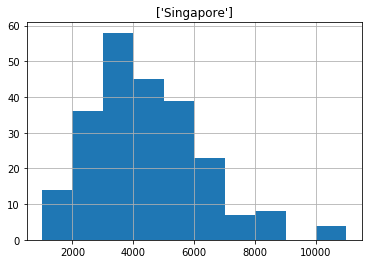

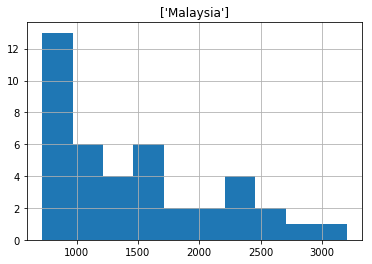

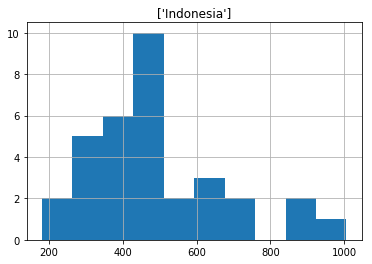

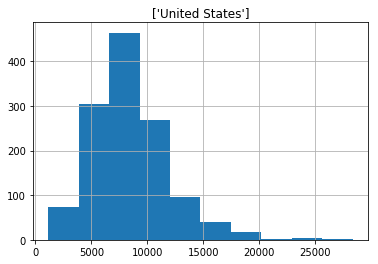

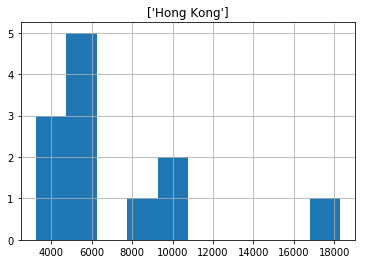

monthlysalaryrange


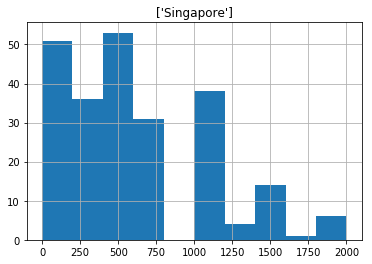

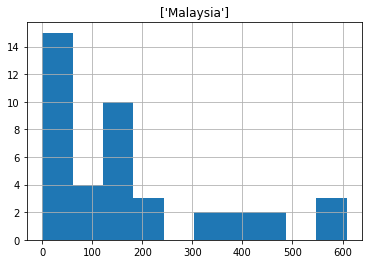

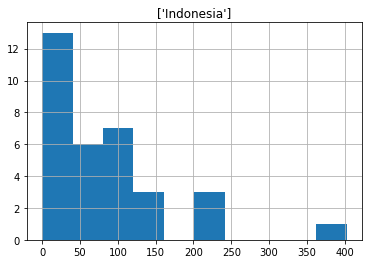

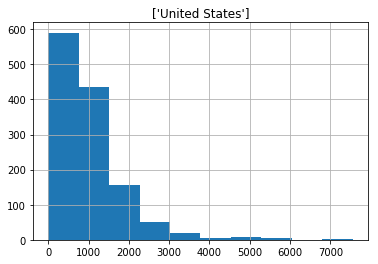

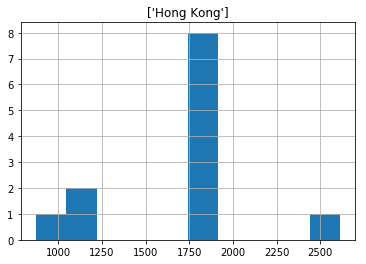

In [59]:
salarycolumns=['monthlyaveragesalary','monthlysalaryrange']
for u in salarycolumns:
    print (u)
    for i in alldf:
        convertDfToSGD(getsalarymetrics(i))[u].hist()
        plt.title(i['country'][0].unique())
        plt.show()

In [60]:
import seaborn as sns
sns.set()

['Singapore']


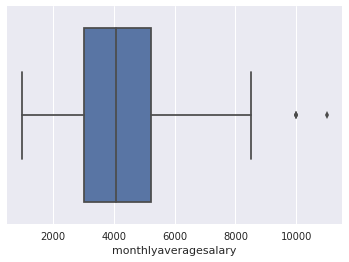

['Malaysia']


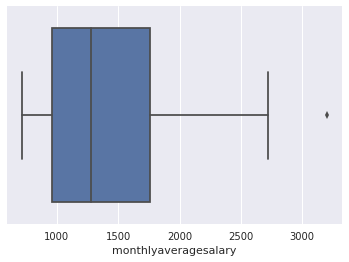

['Indonesia']


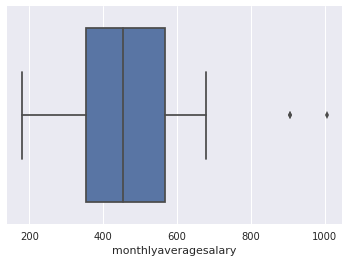

['United States']


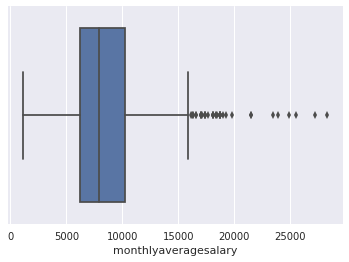

['Hong Kong']


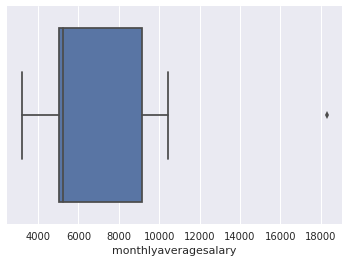

In [68]:
for i in alldf:
    print (i['country'][0].unique())
    sns.boxplot(convertDfToSGD(getsalarymetrics(i))['monthlyaveragesalary'])
    plt.show()

### US per hour salaries

In [69]:

[money for money in [hour for hour in US['salary'].dropna() if 'hour' in hour ] ]

['$22.50 an hour',
 '$11.50 an hour',
 '$10 an hour',
 '$40 - $85 an hour',
 '$60 - $65 an hour',
 '$45 - $75 an hour',
 '$60 - $80 an hour',
 '$10 - $12 an hour',
 '$30 - $36 an hour',
 '$50 an hour',
 '$20 - $26 an hour',
 '$24 an hour',
 '$25 - $28 an hour',
 '$28.71 - $34.90 an hour',
 '$54.18 - $68.15 an hour',
 '$23.99 - $36.54 an hour',
 '$33.54 - $44.01 an hour',
 '$75 an hour',
 '$9 an hour',
 '$32 an hour',
 '$15 an hour',
 '$21.31 - $27.06 an hour',
 '$22.83 - $29.80 an hour',
 '$36.10 - $47.71 an hour',
 '$25 an hour',
 '$32.47 - $42.10 an hour',
 '$32.47 - $42.10 an hour',
 '$25 an hour',
 '$27.80 - $37.53 an hour',
 '$75 an hour',
 '$25 - $30 an hour',
 '$19.60 an hour',
 '$12.53 - $13.56 an hour',
 '$108 an hour',
 '$31.23 - $39.58 an hour',
 '$31.23 - $39.58 an hour',
 '$31.23 - $39.58 an hour',
 '$31.23 - $39.58 an hour',
 '$39.58 - $50.18 an hour',
 '$39.58 - $50.18 an hour',
 '$110 an hour',
 '$13 - $18 an hour',
 '$32.06 - $34.67 an hour',
 '$33.53 - $42.50 an hour'

In [70]:
convertDfToSGD(getsalarymetrics(US))

,paymentcycle,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange,currency,paymentcurrency
0,year,11333.333333,11333.333333,11333.333333,0.000000,SGD,USD
1,year,6800.000000,6800.000000,6800.000000,0.000000,SGD,USD
2,year,7733.640000,9791.773333,8762.706667,1029.066667,SGD,USD
3,year,6849.300000,18302.993333,12576.146667,5726.846667,SGD,USD
4,year,7965.746667,9160.620000,8563.183333,597.436667,SGD,USD
5,year,6289.320000,7997.480000,7143.400000,854.080000,SGD,USD
6,hour,4896.000000,4896.000000,4896.000000,0.000000,SGD,USD
7,year,8911.400000,10336.000000,9623.700000,712.300000,SGD,USD
8,year,8160.000000,9520.000000,8840.000000,680.000000,SGD,USD
9,year,14166.666667,14166.666667,14166.666667,0.000000,SGD,USD


In [71]:
convertDfToSGD(getsalarymetrics(SG)).groupby('paymentcycle').describe()

monthlyaveragesalary                                    \
                            count         mean          std     min   
paymentcycle                                                          
hour                          1.0  1280.000000          NaN  1280.0   
month                       231.0  4292.683983  1743.560495  1000.0   
year                          2.0  4791.666667  5008.673033  1250.0   

                                                              \
                      25%          50%     75%           max   
paymentcycle                                                   
hour          1280.000000  1280.000000  1280.0   1280.000000   
month         3050.000000  4150.000000  5175.0  11000.000000   
year          3020.833333  4791.666667  6562.5   8333.333333   

             monthlyhighsalary                ...   monthlylowsalary  \
                         count         mean   ...                75%   
paymentcycle                                  ...                      
hour                       1.0  1280.000000   ...             1280.0   
month                    231.0  4880.779221   ...             4500.0   
year                       2.0  4791.666667   ...             6562.5   

                           monthlysalaryrange                               \
                       max              count        mean         std  min   
paymentcycle                                                                 
hour           1280.000000                1.0    0.000000         NaN  0.0   
month         10000.000000              231.0  588.095238  480.555665  0.0   
year           8333.333333                2.0    0.000000    0.000000  0.0   

                                            
                25%    50%     75%     max  
paymentcycle                                
hour            0.0    0.0     0.0     0.0  
month         250.0  500.0  1000.0  2000.0  
year            0.0    0.0     0.0     0.0  

[3 rows x 32 columns]

In [72]:
convertDfToSGD(getsalarymetrics(US)).groupby('paymentcycle').describe()

monthlyaveragesalary                                     \
                            count         mean          std      min   
paymentcycle                                                           
day                          15.0  2697.650667  4097.841357  1144.44   
hour                        250.0  7684.530944  4125.834968  1958.40   
month                       157.0  7487.553631  1990.128643  2983.84   
week                          1.0  4819.840000          NaN  4819.84   
year                        848.0  8978.570381  3292.042800  1832.60   

                                                                 \
                      25%       50%           75%           max   
paymentcycle                                                      
day           1360.272000  1632.000   1670.488000  17408.000000   
hour          4814.400000  6934.368   9785.472000  27200.000000   
month         6062.880000  7544.600   8474.160000  13617.000000   
week          4819.840000  4819.840   4819.840000   4819.840000   
year          6799.036667  8500.000  10597.190833  28333.333333   

             monthlyhighsalary                   ...      monthlylowsalary  \
                         count          mean     ...                   75%   
paymentcycle                                     ...                         
day                       15.0   2918.795733     ...               1564.00   
hour                     250.0   8299.699200     ...               8704.00   
month                    157.0   8600.821911     ...               7344.00   
week                       1.0   4819.840000     ...               4819.84   
year                     848.0  10001.990763     ...               9312.60   

                           monthlysalaryrange                                \
                       max              count         mean         std  min   
paymentcycle                                                                  
day           17408.000000               15.0   221.145067  224.266624  0.0   
hour          23936.000000              250.0   615.168256  866.887577  0.0   
month         11332.880000              157.0  1113.268280  830.899095  0.0   
week           4819.840000                1.0     0.000000         NaN  0.0   
year          28333.333333              848.0  1023.420381  906.579588  0.0   

                                                              
                     25%       50%          75%          max  
paymentcycle                                                  
day            27.200000   116.280   385.560000   647.360000  
hour            0.000000   435.200   908.480000  7552.896000  
month         585.480000  1006.400  1566.720000  3743.400000  
week            0.000000     0.000     0.000000     0.000000  
year          283.333333   959.735  1446.855833  5726.846667  

[5 rows x 32 columns]

In [73]:
convertDfToSGD(getsalarymetrics(ID)).groupby('paymentcycle').describe()

monthlyaveragesalary                                   \
                            count        mean      std         min   
paymentcycle                                                         
month                        33.0  491.815184  188.283  181.058704   

                                                            monthlyhighsalary  \
                     25%        50%         75%         max             count   
paymentcycle                                                                    
month         352.058591  452.64676  568.323155  1005.88169              33.0   

                             ...     monthlylowsalary              \
                    mean     ...                  75%         max   
paymentcycle                 ...                                    
month         570.914062     ...           502.940845  905.293521   

             monthlysalaryrange                                        \
                          count       mean        std  min        25%   
paymentcycle                                                            
month                      33.0  79.098878  88.598929  0.0  25.147042   

                                                 
                    50%         75%         max  
paymentcycle                                     
month         50.294084  100.588169  402.352676  

[1 rows x 32 columns]

In [74]:
convertDfToSGD(getsalarymetrics(HK)).groupby('paymentcycle').describe()

monthlyaveragesalary                                       \
                            count        mean         std          min   
paymentcycle                                                             
month                        12.0  7180.10283  4232.49073  3223.423313   

                                                                 \
                      25%         50%          75%          max   
paymentcycle                                                      
month         5052.933842  5227.17294  9147.552645  18295.10529   

             monthlyhighsalary                  ...     monthlylowsalary  \
                         count         mean     ...                  75%   
paymentcycle                                    ...                        
month                     12.0  8813.594374     ...          7405.161665   

                          monthlysalaryrange                           \
                      max              count         mean         std   
paymentcycle                                                            
month         15681.51882               12.0  1633.491544  450.585811   

                                                                          
                    min          25%         50%         75%         max  
paymentcycle                                                              
month         871.19549  1589.931769  1742.39098  1742.39098  2613.58647  

[1 rows x 32 columns]

## Create the fulldf for modelling

In [75]:
traindf = train.reset_index(drop=True).reset_index().merge(getsalarymetrics(train).reset_index().\
drop('currency',axis=1),how='outer',on='index').drop(['index','salary'],axis=1)
traindf.head()

/home/nasdin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,company,country,description,location,review,star,title,currency,paymentcycle,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange
0,UMeKang,Singapore,"Use all available data, undertaking data disco...",Singapore,NaN,NaN,Data Scientist,SGD,month,9000,11000,10000,1000
1,Cresco Data Pte Ltd,Singapore,Data Scientist Duties:. We are looking for a D...,Tanjong Pagar,NaN,NaN,Data Scientist,SGD,month,3500,4500,4000,500
2,Vault Dragon,Singapore,Assist the Data Scientist in deploying Machine...,Singapore,NaN,NaN,Data Engineer,SGD,month,4000,6000,5000,1000
3,TSA Solutions,Singapore,Data Scientist - Summary*. Bachelor in degree ...,Pasir Panjang,NaN,NaN,Data Scientist,SGD,month,4200,4200,4200,0
4,EkkBaz.com,Singapore,We are looking for a Data Scientist that will ...,Ang Mo Kio,NaN,NaN,Data Scientist Intern,SGD,month,1000,2000,1500,500


#### What we are trying to predict

##### Per job
    currency
    Paymentcycle
    monthlylowsalary
    monthlyhighsalary
    monthlyaveragesaary
    monthlysalaryrange

### Based on:
    Company
    Country
    Description
    Job Title
    Location, Country
    Review of Company, Stars
    
#### What we need to feature engineer, 
    Job Title

## Class for title

### Fixed dummy variables

In [76]:
for i in traindf['title'].unique():
    print (i)

Data Scientist
Data Engineer
Data Scientist Intern
Data Crawling Engineer Intern
Robot Software Engineer - Image Processing
Data Visualization and Wrangling Intern
Senior Planning Engineer
Assembly Technician (Production Line)
Production Technician
Post Doctoral Positions
Technical Marine Administrator
Senior Robotics Software Engineer
Service Coordinator
Senior Platform Engineer
Big Data Engineer
Assistant Engineers (Sub-Station Automation), Singapore
Postdoctoral Research Associate – Freight Transportation
Graphic Designer
Sales & Application Engineer
Senior Software Engineer
Senior Software Enginner
Process Engineer (Mechanical)
Planner
Site Engineer (Civil)
Sales Engineer
Graduate Engineer Trainee Programme
Systems Engineer (12-month contract)
Electrical Engineering Technician
Mechanical Engineer
Senior IT Engineer
Test Engineer
Backend Engineer - General
Backend Engineer - Site Reliability
Service Engineer (West / Entry / Class 3 / Nitec / Singaporean)
Network Engineer
CCTV Engine

## Cleaning the Title with NLP

In [77]:
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

In [78]:
lemm = WordNetLemmatizer()
stem = SnowballStemmer('english')

In [79]:
JobKeywords = ['data scientist','scientist','analyst','engineer','intern',
               'junior','senior','sr','jr','data analyst','data engineer',
               'technician','full stack','vp','director',
               'lead','head','staff','manager','supervisor','financial',
               'quantitative','developer','support','entry','data entry','i','ii','fellow','research','clerk']

pjobkeywords = [WordNetLemmatizer().lemmatize(SnowballStemmer('english').stem(jobs)) for jobs in JobKeywords]

In [80]:
pjobkeywords

['data scientist',
 'scientist',
 'analyst',
 'engin',
 'intern',
 'junior',
 'senior',
 'sr',
 'jr',
 'data analyst',
 'data engin',
 'technician',
 'full stack',
 'vp',
 'director',
 'lead',
 'head',
 'staff',
 'manag',
 'supervisor',
 'financi',
 'quantit',
 'develop',
 'support',
 'entri',
 'data entri',
 'i',
 'ii',
 'fellow',
 'research',
 'clerk']

In [81]:
traindf.join(pd.DataFrame(columns=pjobkeywords))

,company,country,description,location,review,star,title,currency,paymentcycle,monthlylowsalary,...,quantit,develop,support,entri,data entri,i,ii,fellow,research,clerk
0,UMeKang,Singapore,"Use all available data, undertaking data disco...",Singapore,NaN,NaN,Data Scientist,SGD,month,9000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cresco Data Pte Ltd,Singapore,Data Scientist Duties:. We are looking for a D...,Tanjong Pagar,NaN,NaN,Data Scientist,SGD,month,3500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Vault Dragon,Singapore,Assist the Data Scientist in deploying Machine...,Singapore,NaN,NaN,Data Engineer,SGD,month,4000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TSA Solutions,Singapore,Data Scientist - Summary*. Bachelor in degree ...,Pasir Panjang,NaN,NaN,Data Scientist,SGD,month,4200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EkkBaz.com,Singapore,We are looking for a Data Scientist that will ...,Ang Mo Kio,NaN,NaN,Data Scientist Intern,SGD,month,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6Estates Pte Ltd,Singapore,Assist to organise unstructured data on websit...,Singapore,NaN,NaN,Data Crawling Engineer Intern,SGD,month,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Transforma,Singapore,Develop and implement algorithms for 3D recons...,Singapore,NaN,NaN,Robot Software Engineer - Image Processing,SGD,month,3500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Shentilium Technologies,Singapore,"Perform ETL, data cleaning and data crowdsourc...",Singapore,NaN,NaN,Data Visualization and Wrangling Intern,SGD,month,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,6Estates Pte Ltd,Singapore,Assist Data Crawling Engineer to sift through ...,Singapore,NaN,NaN,Data Crawling Engineer Intern,SGD,month,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Noggin Pte Ltd,Singapore,We are looking for a Data Engineer with a stro...,Singapore,NaN,NaN,Data Engineer,SGD,month,4000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
def NLP(word):
            wurd = str(word)
            wurd = lemm.lemmatize(str((wurd)))
            wurd = stem.stem(str((wurd)))
            return wurd

In [83]:
class ProcessTitle(BaseEstimator, TransformerMixin):
    def __init__(self):
        
        
       
        
        
        
        pass
    
    
    
    def transform(self,X, *args):
        
        df = X.copy()
        
        #create dummy columns 
        for i in pjobkeywords:
            df[i] = 0
        lemm = WordNetLemmatizer()
        stem = SnowballStemmer('english')
        
        df.reset_index(inplace=True,drop=True)
        
            
        
        #process title
        df['title']= df['title'].apply(NLP)
                                               
        #iterate through the entire dataframe
        for job in pjobkeywords:
            for i in np.arange(df.shape[0]):
                if job in str(df.iloc[i]['title']):
                    df.set_value(i,job,1)
                
            
            #print (self.df.iloc[i]['title'])
       #     #scan through the pjobkeywords
       #     for job in pjobkeywords:
       #         if job in self.df.iloc[i]['title']:
       #             #if title contains this keyword, change the keyword column to 1, else to 0
       #             self.df.iloc[i][job] =1
       #         else:
       #             self.df.iloc[i][job] = 0
        #return the output self.df    
        
        return df[pjobkeywords].values

    def fit(self, X, *args):
        #self.df = df
        return self

In [84]:
nlptitle = ProcessTitle()


In [85]:
nlptitle.fit(traindf)

ProcessTitle()

In [86]:
nlptitle.transform(traindf)

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

### Prepare the train and test

In [87]:
from sklearn.model_selection import train_test_split

### Convert the money to sgd

In [88]:
traindf = convertDfToSGD(traindf)

In [89]:
X = traindf[['company', 'country', 'description', 'location', 'review', 'star',
       'title']]
y = traindf [['paymentcycle', 'monthlylowsalary',
       'monthlyhighsalary', 'monthlyaveragesalary', 'monthlysalaryrange']]

In [110]:
traindf[traindf['country']=='Indonesia']

,company,country,description,location,review,star,title,currency,paymentcycle,monthlylowsalary,monthlyhighsalary,monthlyaveragesalary,monthlysalaryrange,paymentcurrency
234,PT JAVINCI BERKAT KREATIF SENTOSA,Indonesia,Memahami teknik perawatan kulit. Mencatat data...,Jakarta,NaN,NaN,Beauty Advisor ( SPG ),SGD,month,181.058704,181.058704,181.058704,0.000000,IDR
235,PT Hexaon Business Mitrasindo,Indonesia,TECHNICAL SUPPORT ENGINEER Job Description -Ma...,Jakarta,NaN,NaN,TECHNICAL SUPPORT ENGINEER,SGD,month,352.058591,452.646760,402.352676,50.294084,IDR
236,OSELLA,Indonesia,Create personnel data report payroll. Candidat...,Jakarta,NaN,NaN,HRIS Manager,SGD,month,804.705352,1005.881690,905.293521,100.588169,IDR
237,PT RAJAWALI ANUGRAH RESOURCES,Indonesia,Pendidikan D3 Teknik Elektro. RAJAWALI ANUGRAH...,Jakarta,NaN,NaN,HELPDESK SUPPORT,SGD,month,402.352676,502.940845,452.646760,50.294084,IDR
238,Manpower Business Solutions,Indonesia,Data analysis and making designated reports/de...,Jakarta,NaN,NaN,Quality Analyst,SGD,month,452.646760,452.646760,452.646760,0.000000,IDR
239,PT RAJAWALI ANUGRAH RESOURCES,Indonesia,Compliance and quality analyst:. Pengalaman mi...,Jakarta,NaN,NaN,COMPLIANCE AND QUALITY MANAGER,SGD,month,905.293521,1106.469859,1005.881690,100.588169,IDR
240,Verint,Indonesia,Are educated to a computer science or software...,Jakarta,NaN,NaN,Java Web Programmer,SGD,month,553.234930,804.705352,678.970141,125.735211,IDR
241,PT Era Daya Potensia,Indonesia,1.Minimal pendidikan D3/S1 dari jurusan teknik...,Jakarta,NaN,NaN,Technical Support (IT Support)-Bintaro Jaya,SGD,month,251.470422,301.764507,276.617465,25.147042,IDR
242,PT. Texmura,Indonesia,Menguasai Software Design (AutoCAD atau sejeni...,Jakarta,NaN,NaN,DRAFTER,SGD,month,402.352676,502.940845,452.646760,50.294084,IDR
243,Primajaya Group,Indonesia,S1 Sarjana Teknik Elektro/ Teknik Mesin. Mengu...,Jakarta,NaN,NaN,Drafter MEP,SGD,month,502.940845,502.940845,502.940845,0.000000,IDR


In [90]:
X_test, X_train, y_test, y_train = train_test_split(X,y,test_size=0.33, random_state=42)

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer

### Feature engineer the other columns

In [92]:
class specificcolumn(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    #just returns company country location as is
    
         
        
    
    def transform(self, *args):
        
        
        return self.X[self.columns]

    def fit(self, X, *args):
        self.X = X
        return self

In [93]:
class zeroimputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        
    #just returns description as is
    
        pass
        
    
    def transform(self, *args):
        
        for i in self.X.columns:
            self.X.loc[pd.isnull(self.X[i]),i]=0
        
        return self.X
    def fit(self, X, *args):
        self.X = pd.DataFrame(X)
        return self

In [94]:
import autosklearn.classification
cls = autosklearn.classification.AutoSklearnClassifier()

## Create Pipelines

In [95]:
from sklearn.pipeline import make_pipeline as pipeline
from sklearn.pipeline import make_union as union
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import strip_accents_unicode
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [96]:
numbers = union(pipeline(specificcolumn('review'),zeroimputer(),RobustScaler()),
                pipeline(specificcolumn('star'),zeroimputer(),RobustScaler()))

In [130]:
class pipelinewords(BaseEstimator, TransformerMixin):
    def __init__(self,column):
        self.column = column
    #just returns description as is
    
        pass
        
    
    def transform(self, X, *args):
        
        labelencoded = LabelEncoder().fit_transform(specificcolumn(self.column).fit_transform(X)).reshape(-1,1)
        return labelencoded
        
        
    def fit(self, X, *args):
        
        return self


In [131]:
country = pipelinewords('country')
company = pipelinewords('company')
location = pipelinewords('location')


In [132]:
magic = union ( numbers,country,company,location,ProcessTitle())

### Fit the pipeline

In [100]:
magicX_train = pd.DataFrame(magic.fit_transform(X_train))
magicX_test= pd.DataFrame(magic.fit_transform(X_test))

In [101]:
magicX_train.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.700516,0.058824,4.0,252.0,147.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.061962,-0.811765,4.0,123.0,35.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.096386,0.000000,4.0,23.0,42.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.061962,-0.811765,1.0,196.0,86.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.984509,0.023529,4.0,253.0,177.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Predicting averagesalary

In [233]:
y_train_monthlyaveragesalary = y_train['monthlyaveragesalary'].apply(int).values.reshape(-1,1)
y_test_monthlyaveragesalary = y_test['monthlyaveragesalary'].apply(int).values.reshape(-1,1)

In [234]:
cls.fit(magicX_train,y_train_monthlyaveragesalary)

/home/nasdin/anaconda3/lib/python3.6/site-packages/autosklearn/estimators.py:556: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  y = self._process_target_classes(y)


[WARNING] [2017-10-27 12:27:24,642:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 12:27:24,642:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 12:33:15,102:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 12:33:15,102:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 12:34:10,208:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 12:34:10,208:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 12:34:14,950:smac.intensification.intensificatio

In [235]:
y_hat = cls.predict(magicX_test)

In [236]:
X_testcopy = X_test.copy()
X_testcopy['predicted'] = y_hat
X_testcopy['actual'] = y_test_monthlyaveragesalary

In [114]:
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score , roc_curve

In [239]:
print("mse", mean_squared_error(y_test_monthlyaveragesalary, y_hat))
print("accuracy", accuracy_score(y_test_monthlyaveragesalary, y_hat))


mse 15876413.8808
accuracy 0.00469483568075


### Using this trained model to estimate the average salary of jobs that did not provide salary data

In [118]:
test.drop('salary',axis=1,inplace=True)

AttributeError: 'str' object has no attribute 'drop'

In [119]:
def getridofstupidshit(weirdstring):
    try:
        weirdstring = str(weirdstring)
    except:
        pass
    shit ='<>?,.;":[]{}\|/-=_+!@#$%^&*()'
    for poop in shit:
        while poop in weirdstring:
            try:
                weirdstring = weirdstring.replace(poop," ")
            except:
                pass
    return weirdstring

test['title']=test['title'].apply(getridofstupidshit)
test['company']=test['company'].apply(getridofstupidshit)
test['location']=test['location'].apply(getridofstupidshit)

TypeError: string indices must be integers

In [261]:
magic_test = (magic.fit_transform(test))

## At this point my kernel died and I lost my model and I got sad

In [2]:
test_hat = cls.predict(magic_test)

NameError: name 'cls' is not defined

In [262]:
test['predictedmonthlyaveragesalary'] = test_hat

MemoryError: 

In [ ]:
test

## Bonus Question

### Using easier parameters

### Predicting low salary

In [104]:
y_train_monthlylowsalary = y_train['monthlylowsalary'].apply(int).values.reshape(-1,1)
y_test_monthlylowsalary = y_test['monthlylowsalary'].apply(int).values.reshape(-1,1)

In [105]:
clsmonthlylowsalary = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=30,per_run_time_limit=30, include_estimators=["random_forest", ], exclude_estimators=None,
     include_preprocessors=["no_preprocessing", ], exclude_preprocessors=None)

In [111]:
clsmonthlylowsalary.fit(magicX_train,y_train_monthlylowsalary)

/home/nasdin/anaconda3/lib/python3.6/site-packages/autosklearn/estimators.py:556: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  y = self._process_target_classes(y)


Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (29.696638)
[WARNING] [2017-10-27 14:13:52,887:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 14:13:52,887:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 14:13:52,889:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 14:13:52,889:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 14:13:52,891:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 14:13:52,891:smac.intensification.intensification.Intensifier] 

In [112]:
y_predictedlowsalary = clsmonthlylowsalary.predict(magicX_test)

In [115]:
print("Accuracy score", accuracy_score(y_test_monthlylowsalary, y_predictedlowsalary))
print("mse", mean_squared_error(y_test_monthlylowsalary, y_predictedlowsalary))

Accuracy score 0.00469483568075
mse 12075525.0103


### Predicting range of salary

In [ ]:
y_train_salaryrange = y_train['monthlysalaryrange'].apply(int).values.reshape(-1,1)
y_test_salaryrange = y_test['monthlysalaryrange'].apply(int).values.reshape(-1,1)

clssalaryrange = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=30,per_run_time_limit=30, include_estimators=["random_forest", ], exclude_estimators=None,
     include_preprocessors=["no_preprocessing", ], exclude_preprocessors=None)

clssalaryrange.fit(magicX_train,y_train_salaryrange)

y_predictedsalaryrange = clssalaryrange.predict(magicX_test)

In [117]:
print("Accuracy score", accuracy_score(y_test_salaryrange, y_predictedsalaryrange))
print("mse", mean_squared_error(y_test_salaryrange, y_predictedsalaryrange))

Accuracy score 0.174647887324
mse 1307620.73615


## Predicting low salaries for jobs that did not provide salaries

### To give a low estimate. take Low of estimated salary - range of salary

In [124]:
test

,company,country,description,location,review,salary,star,title,currency
0,Singapore Power,Singapore,"Singapore Power is looking for data analysts, ...",Singapore,6.0,None,51.0,Data Analyst/Data Scientist/Data and Machine L...,SGD
1,Skyscanner,Singapore,What you can expect as a data scientist. Previ...,Singapore,3.0,None,51.0,Data Scientist – Singapore,SGD
2,Siemens AG,Singapore,Siemens Healthineers is hiring a Data Scientis...,Singapore,5293.0,None,51.6,Data Scientist,SGD
3,GIC Investment,Singapore,Acquire data from primary or secondary data so...,Tanjong Pagar,NaN,None,NaN,"VP, Data Scientist",SGD
4,Procter & Gamble,Singapore,"Scope includes acquiring, cleaning, formatting...",Singapore,3703.0,None,52.2,Research & Development - Data Transformation S...,SGD
5,Singapore Press Holdings,Singapore,Knowledge of Data Warehouse concept. The Data ...,North Singapore,17.0,None,42.6,Data Scientist,SGD
6,Credit Suisse,Singapore,Dealing with critical and confidential data wo...,Singapore,978.0,None,44.4,Data Scientist,SGD
7,StarHub,Singapore,"Data Scientist , SmartHub. Mine large volume o...",Singapore,30.0,None,42.6,"Data Scientist , SmartHub",SGD
9,Ahrefs,Singapore,"Experience with Elasticsearch or similar DB, a...",Singapore,NaN,None,NaN,Data Scientist (Big Data Analytics),SGD
10,ResMed,Singapore,Scientist - Big Data Analytics. The Scientist-...,Singapore,61.0,None,43.8,Scientist - Big Data Analytics,SGD


In [125]:
def getridofstupidshit(weirdstring):
    try:
        weirdstring = str(weirdstring)
    except:
        pass
    shit ='<>?,.;":[]{}\|/-=_+!@#$%^&*()'
    for poop in shit:
        while poop in weirdstring:
            try:
                weirdstring = weirdstring.replace(poop," ")
            except:
                pass
    return weirdstring

test['title']=test['title'].apply(getridofstupidshit)
test['company']=test['company'].apply(getridofstupidshit)
test['location']=test['location'].apply(getridofstupidshit)

/home/nasdin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/nasdin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/nasdin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [133]:
magic_test = pd.DataFrame(magic.fit_transform(test))

In [134]:
predictedlowsalary = clsmonthlylowsalary.predict(magic_test)
predictedsalaryrange = clssalaryrange.predict(magic_test)

In [138]:
predicteddf = test.copy()
predicteddf['predictedlowsalary'] = predictedlowsalary
predicteddf['predictedsalaryrange'] = predictedsalaryrange
predicteddf.drop('currency',inplace=True,axis=1)

### Display the predictions

In [139]:
predicteddf

,company,country,description,location,review,salary,star,title,predictedlowsalary,predictedsalaryrange
0,Singapore Power,Singapore,"Singapore Power is looking for data analysts, ...",Singapore,6.0,None,51.0,Data Analyst Data Scientist Data and Machine L...,2200,0
1,Skyscanner,Singapore,What you can expect as a data scientist. Previ...,Singapore,3.0,None,51.0,Data Scientist – Singapore,3264,0
2,Siemens AG,Singapore,Siemens Healthineers is hiring a Data Scientis...,Singapore,5293.0,None,51.6,Data Scientist,3264,0
3,GIC Investment,Singapore,Acquire data from primary or secondary data so...,Tanjong Pagar,NaN,None,NaN,VP Data Scientist,2200,0
4,Procter Gamble,Singapore,"Scope includes acquiring, cleaning, formatting...",Singapore,3703.0,None,52.2,Research Development Data Transformation S...,2200,0
5,Singapore Press Holdings,Singapore,Knowledge of Data Warehouse concept. The Data ...,North Singapore,17.0,None,42.6,Data Scientist,3264,0
6,Credit Suisse,Singapore,Dealing with critical and confidential data wo...,Singapore,978.0,None,44.4,Data Scientist,7916,0
7,StarHub,Singapore,"Data Scientist , SmartHub. Mine large volume o...",Singapore,30.0,None,42.6,Data Scientist SmartHub,3264,0
9,Ahrefs,Singapore,"Experience with Elasticsearch or similar DB, a...",Singapore,NaN,None,NaN,Data Scientist Big Data Analytics,2200,0
10,ResMed,Singapore,Scientist - Big Data Analytics. The Scientist-...,Singapore,61.0,None,43.8,Scientist Big Data Analytics,3264,0


In [141]:
predicteddf.loc[predicteddf['country']=='Indonesia']

,company,country,description,location,review,salary,star,title,predictedlowsalary,predictedsalaryrange
3582,PT United Tractors Tbk,Indonesia,The person also need to have deep understandin...,Indonesia,NaN,None,NaN,Data Scientist,2800,0
3583,Nielsen,Indonesia,Leading a team of Data Scientist :. 10 years D...,Indonesia,NaN,None,NaN,Data Science Leader,2000,116
3584,PT Xtremax Teknologi Indonesia,Indonesia,At least 2 years experiences working with data...,Bandung,NaN,None,NaN,Data Scientist,2800,0
3585,Atreus Global,Indonesia,Data mining using state-of-the-art methods. Pr...,Jakarta,NaN,None,NaN,Data Scientist,2800,0
3586,HappyFresh,Indonesia,Understanding of reporting systems and efficie...,Jakarta,NaN,None,NaN,Data Scientist,2800,0
3587,Traveloka,Indonesia,"As a Data scientist, you play a key role to so...",Jakarta,4.000,None,51.0,Data Scientist,3264,0
3588,Traveloka,Indonesia,"As an Associate Data scientist, you play a key...",Jakarta,4.000,None,51.0,Associate Data Scientist,3264,0
3589,Excellerate,Indonesia,Experience in data mining and data analysis. M...,Jakarta,NaN,None,NaN,Data Scientist,2800,0
3590,Infomedia Nusantara,Indonesia,Pengolahan Big Data. Membuat solusi dari anali...,Jakarta,NaN,None,NaN,Data Scientist,2800,116
3591,EY,Indonesia,We go beyond strategy and provide end to end i...,Jakarta,3.881,None,51.0,Performance Improvement Analytics Data Sci...,3264,0


### Very far off

# Isolating just by 1 country, US

In [188]:
US = US.dropna(axis=0,subset=['salary'])

In [189]:
USdf = US.reset_index(drop=True).reset_index().merge(getsalarymetrics(US).reset_index().\
drop('currency',axis=1),how='outer',on='index').dropna(axis=0,subset=['salary'])

/home/nasdin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [190]:
USdf['title']=USdf['title'].apply(getridofstupidshit)
USdf['company']=USdf['company'].apply(getridofstupidshit)
USdf['location']=USdf['location'].apply(getridofstupidshit)

In [191]:
USdf['salary'].isnull().sum()

0

In [192]:
US_x = USdf[['company', 'country', 'description', 'location', 'review', 'star',
       'title']]
US_y = USdf [['paymentcycle', 'monthlylowsalary',
       'monthlyhighsalary', 'monthlyaveragesalary', 'monthlysalaryrange']]

In [193]:
US_x_test, US_x_train, US_y_test, US_y_train = train_test_split(US_x,US_y,test_size=0.33, random_state=42)

In [194]:
US_magicX_train = pd.DataFrame(magic.fit_transform(US_x_train))
US_magicX_test= pd.DataFrame(magic.fit_transform(US_x_test))

In [195]:
US_y_train_monthlyaveragesalary = US_y_train['monthlyaveragesalary'].apply(int).values.reshape(-1,1)
US_y_test_monthlyaveragesalary = US_y_test['monthlyaveragesalary'].apply(int).values.reshape(-1,1)

In [221]:
usautoml = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=3600,per_run_time_limit=30, include_estimators=["random_forest", ], exclude_estimators=None,
     exclude_preprocessors=None)

In [222]:
usautoml.fit(US_magicX_train,US_y_train_monthlyaveragesalary)

/home/nasdin/anaconda3/lib/python3.6/site-packages/autosklearn/estimators.py:556: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  y = self._process_target_classes(y)
Process pynisher function call:
Traceback (most recent call last):
  File "/home/nasdin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/nasdin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nasdin/anaconda3/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/home/nasdin/anaconda3/lib/python3.6/site-packages/autosklearn/smbo.py", line 319, in _calculate_metafeatures_encoded
    self.logger)
  File "/home/nasdin/anaconda3/lib/python3.6/site-packages/autosklearn/smbo.py", line 127, in _ca

[WARNING] [2017-10-27 15:13:50,174:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:13:50,174:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:13:50,176:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:13:50,176:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:13:50,178:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:13:50,178:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:13:52,303:smac.intensification.intensificatio

[WARNING] [2017-10-27 15:18:08,688:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:18:10,779:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:18:10,779:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:18:30,423:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:18:30,423:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:18:42,221:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:18:42,221:smac.intensification.intensificatio

[WARNING] [2017-10-27 15:39:33,810:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:39:33,810:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:39:48,468:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:39:48,468:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:41:19,578:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:41:19,578:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 15:42:30,863:smac.intensification.intensificatio

[WARNING] [2017-10-27 15:59:47,707:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 16:02:49,261:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 16:02:49,261:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 16:03:18,709:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 16:03:18,709:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 16:06:43,544:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2017-10-27 16:06:43,544:smac.intensification.intensificatio

In [223]:
US_predictedsalaryrange = usautoml.predict(US_magicX_test)

In [224]:
UStestcheck = US_x_test.copy()
UStestcheck['actual'] = US_y_test_monthlyaveragesalary
UStestcheck['predicted'] = US_predictedsalaryrange


In [225]:
UStestcheck.head()

,company,country,description,location,review,star,title,actual,predicted
723,The University of Pittsburgh,United States,Consults with senior scientists and scientific...,Pittsburgh PA,378.0,52.2,Research Technician,2567,1772
311,Washington State Dept of Transportation,United States,"(Prefer statistical applications such as R, or...",Olympia WA,11.0,43.8,Transportation Research Analyst TPS1 2 Posi...,4556,4116
1090,System One,United States,Responsibilities may also include participatio...,Houston TX 77057 Galleria Uptown area,138.0,43.8,Java Developer,8800,2750
430,City of Tacoma,United States,"Provides training, produces analyses and repor...",Tacoma WA,21.0,51.6,Senior Human Resources Analyst Classification...,7001,6181
549,Los Angeles County Human Resources,United States,A multiple choice test measuring Quantitative ...,Los Angeles County CA,NaN,NaN,Human Resources Analyst IV Information Techn...,8725,1840


In [226]:
print("Accuracy score", accuracy_score(US_y_test_monthlyaveragesalary, US_predictedsalaryrange))
print("mse", mean_squared_error(US_y_test_monthlyaveragesalary, US_predictedsalaryrange))

Accuracy score 0.00117508813161
mse 10683986.1187
